#### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF-Hub CORD-19 Swivel 埋め込みを探索する


<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/cord_19_embeddings_keras">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/hub/tutorials/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/hub/tutorials/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a>
</td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/hub/tutorials/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
  <td>     <a href="https://tfhub.dev/tensorflow/cord-19/swivel-128d/3"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub モデルを参照</a>   </td>
</table>

TF-Hub (https://tfhub.dev/tensorflow/cord-19/swivel-128d/3) の CORD-19 Swivel テキスト埋め込みモジュールは、COVID-19 に関連する自然言語テキストを分析する研究者をサポートするために構築されました。これらの埋め込みは、[CORD-19 データセット](https://api.semanticscholar.org/CorpusID:216056360)の論文のタイトル、著者、抄録、本文、および参照タイトルをトレーニングしています。

この Colab では、以下について取り上げます。

- 埋め込み空間内の意味的に類似した単語の分析
- CORD-19 埋め込みを使用した SciCite データセットによる分類器のトレーニング


## セットアップ


In [2]:
import functools
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tqdm import trange

2024-01-11 19:07:47.276545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:07:47.276588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:07:47.278343: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 埋め込みを分析する

まず、異なる単語間の相関行列を計算してプロットし、埋め込みを分析してみましょう。異なる単語の意味をうまく捉えられるように埋め込みが学習できていれば、意味的に似た単語の埋め込みベクトルは近くにあるはずです。COVID-19 関連の用語をいくつか見てみましょう。

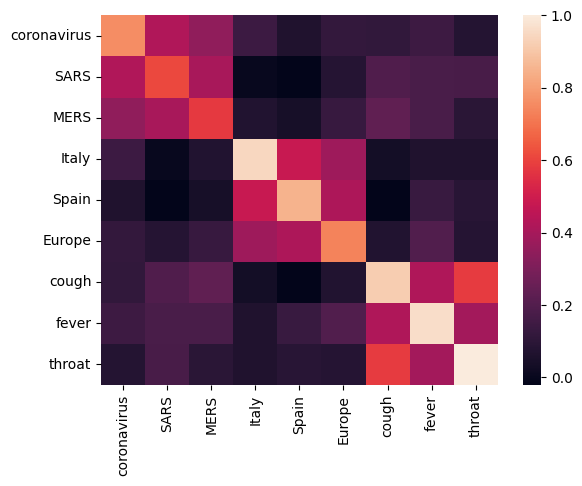

In [3]:
# Use the inner product between two embedding vectors as the similarity measure
def plot_correlation(labels, features):
  corr = np.inner(features, features)
  corr /= np.max(corr)
  sns.heatmap(corr, xticklabels=labels, yticklabels=labels)

# Generate embeddings for some terms
queries = [
  # Related viruses
  'coronavirus', 'SARS', 'MERS',
  # Regions
  'Italy', 'Spain', 'Europe',
  # Symptoms
  'cough', 'fever', 'throat'
]

module = hub.load('https://tfhub.dev/tensorflow/cord-19/swivel-128d/3')
embeddings = module(queries)

plot_correlation(queries, embeddings)

埋め込みが異なる用語の意味をうまく捉えていることが分かります。それぞれの単語は所属するクラスタの他の単語に類似していますが（「コロナウイルス」は「SARS」や「MERS」と高い関連性がある）、ほかのクラスタの単語とは異なります（「SARS」と「スペイン」の類似度はゼロに近い）。

では、これらの埋め込みを使用して特定のタスクを解決する方法を見てみましょう。

## SciCite: 引用の意図の分類

このセクションでは、テキスト分類など下流のタスクに埋め込みを使う方法を示します。学術論文の引用の意図の分類には、TensorFlow Dataset の [SciCite データセット](https://www.tensorflow.org/datasets/catalog/scicite)を使用します。学術論文からの引用がある文章がある場合に、その引用の主な意図が背景情報、方法の使用、または結果の比較のうち、どれであるかを分類します。

In [4]:
builder = tfds.builder(name='scicite')
builder.download_and_prepare()
train_data, validation_data, test_data = builder.as_dataset(
    split=('train', 'validation', 'test'),
    as_supervised=True)

In [5]:
#@title Let's take a look at a few labeled examples from the training set
NUM_EXAMPLES =   10#@param {type:"integer"}

TEXT_FEATURE_NAME = builder.info.supervised_keys[0]
LABEL_NAME = builder.info.supervised_keys[1]

def label2str(numeric_label):
  m = builder.info.features[LABEL_NAME].names
  return m[numeric_label]

data = next(iter(train_data.batch(NUM_EXAMPLES)))


pd.DataFrame({
    TEXT_FEATURE_NAME: [ex.numpy().decode('utf8') for ex in data[0]],
    LABEL_NAME: [label2str(x) for x in data[1]]
})

string       label
0  The finding that BMI is closely related to TBF...      result
1  The average magnitude of the NBR increases wit...  background
2  It has been reported that NF-κB activation can...      result
3  , 2008; Quraan and Cheyne, 2008; Quraan and Ch...  background
4  5B), but, interestingly, they shared conserved...  background
5  Some investigators have noted an association o...  background
6  In our previous study, it is documented that b...  background
7  These subjects have intact cognitive function ...  background
8  Another study reported improved knee function ...  background
9  C. Data Analysis Transcription Speech samples ...      method

## 引用の意図分類器をトレーニングする

分類器のトレーニングには、[SciCite データセット](https://www.tensorflow.org/datasets/catalog/scicite)に対して Keras を使用します。上に分類レイヤーを持ち、CORD-19 埋め込みを使用するモデルを構築してみましょう。

In [6]:
#@title Hyperparameters { run: "auto" }

EMBEDDING = 'https://tfhub.dev/tensorflow/cord-19/swivel-128d/3'  #@param {type: "string"}
TRAINABLE_MODULE = False  #@param {type: "boolean"}

hub_layer = hub.KerasLayer(EMBEDDING, input_shape=[], 
                           dtype=tf.string, trainable=TRAINABLE_MODULE)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(3))
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 128)               17301632  


 dense (Dense)               (None, 3)                 387       


Total params: 17302019 (132.00 MB)


Trainable params: 387 (1.51 KB)


Non-trainable params: 17301632 (132.00 MB)


_________________________________________________________________


## モデルをトレーニングして評価する

モデルをトレーニングして評価を行い、SciCite タスクでのパフォーマンスを見てみましょう。

In [7]:
EPOCHS = 35#@param {type: "integer"}
BATCH_SIZE = 32#@param {type: "integer"}

history = model.fit(train_data.shuffle(10000).batch(BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=validation_data.batch(BATCH_SIZE),
                    verbose=1)

Epoch 1/35


  1/257 [..............................] - ETA: 4:42 - loss: 0.9825 - accuracy: 0.5625

 15/257 [>.............................] - ETA: 0s - loss: 1.0672 - accuracy: 0.4938  

I0000 00:00:1705000078.803553   91317 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 31/257 [==>...........................] - ETA: 0s - loss: 1.0500 - accuracy: 0.5171

 47/257 [====>.........................] - ETA: 0s - loss: 1.0299 - accuracy: 0.5352

 63/257 [======>.......................] - ETA: 0s - loss: 1.0144 - accuracy: 0.5392

 79/257 [========>.....................] - ETA: 0s - loss: 0.9970 - accuracy: 0.5455

 95/257 [==========>...................] - ETA: 0s - loss: 0.9899 - accuracy: 0.5451

111/257 [===========>..................] - ETA: 0s - loss: 0.9745 - accuracy: 0.5515

127/257 [=============>................] - ETA: 0s - loss: 0.9593 - accuracy: 0.5586

143/257 [===============>..............] - ETA: 0s - loss: 0.9493 - accuracy: 0.5629

159/257 [=================>............] - ETA: 0s - loss: 0.9415 - accuracy: 0.5692

175/257 [===================>..........] - ETA: 0s - loss: 0.9313 - accuracy: 0.5763

191/257 [=====================>........] - ETA: 0s - loss: 0.9226 - accuracy: 0.5807

207/257 [=======================>......] - ETA: 0s - loss: 0.9082 - accuracy: 0.5900

223/257 [=========================>....] - ETA: 0s - loss: 0.8996 - accuracy: 0.5949

239/257 [==========================>...] - ETA: 0s - loss: 0.8920 - accuracy: 0.5992

255/257 [============================>.] - ETA: 0s - loss: 0.8828 - accuracy: 0.6042

257/257 [==============================] - 3s 5ms/step - loss: 0.8821 - accuracy: 0.6047 - val_loss: 0.7713 - val_accuracy: 0.6779


Epoch 2/35


  1/257 [..............................] - ETA: 1:27 - loss: 0.6100 - accuracy: 0.7812

 16/257 [>.............................] - ETA: 0s - loss: 0.7221 - accuracy: 0.6953  

 33/257 [==>...........................] - ETA: 0s - loss: 0.7239 - accuracy: 0.6951

 48/257 [====>.........................] - ETA: 0s - loss: 0.7175 - accuracy: 0.6992

 63/257 [======>.......................] - ETA: 0s - loss: 0.7097 - accuracy: 0.7078

 79/257 [========>.....................] - ETA: 0s - loss: 0.7119 - accuracy: 0.7057

 95/257 [==========>...................] - ETA: 0s - loss: 0.7088 - accuracy: 0.7095

110/257 [===========>..................] - ETA: 0s - loss: 0.7054 - accuracy: 0.7139

125/257 [=============>................] - ETA: 0s - loss: 0.7053 - accuracy: 0.7145

141/257 [===============>..............] - ETA: 0s - loss: 0.7013 - accuracy: 0.7172

157/257 [=================>............] - ETA: 0s - loss: 0.6955 - accuracy: 0.7199

172/257 [===================>..........] - ETA: 0s - loss: 0.6985 - accuracy: 0.7171

188/257 [====================>.........] - ETA: 0s - loss: 0.6967 - accuracy: 0.7192

203/257 [======================>.......] - ETA: 0s - loss: 0.6936 - accuracy: 0.7206

218/257 [========================>.....] - ETA: 0s - loss: 0.6931 - accuracy: 0.7215

233/257 [==========================>...] - ETA: 0s - loss: 0.6923 - accuracy: 0.7216

248/257 [===========================>..] - ETA: 0s - loss: 0.6900 - accuracy: 0.7235

257/257 [==============================] - 2s 5ms/step - loss: 0.6886 - accuracy: 0.7248 - val_loss: 0.6688 - val_accuracy: 0.7391


Epoch 3/35


  1/257 [..............................] - ETA: 1:32 - loss: 0.7164 - accuracy: 0.7500

 16/257 [>.............................] - ETA: 0s - loss: 0.6414 - accuracy: 0.7539  

 32/257 [==>...........................] - ETA: 0s - loss: 0.6509 - accuracy: 0.7490

 48/257 [====>.........................] - ETA: 0s - loss: 0.6475 - accuracy: 0.7474

 64/257 [======>.......................] - ETA: 0s - loss: 0.6375 - accuracy: 0.7544

 80/257 [========>.....................] - ETA: 0s - loss: 0.6390 - accuracy: 0.7461

 96/257 [==========>...................] - ETA: 0s - loss: 0.6320 - accuracy: 0.7497

112/257 [============>.................] - ETA: 0s - loss: 0.6323 - accuracy: 0.7492

128/257 [=============>................] - ETA: 0s - loss: 0.6302 - accuracy: 0.7507

144/257 [===============>..............] - ETA: 0s - loss: 0.6281 - accuracy: 0.7500

160/257 [=================>............] - ETA: 0s - loss: 0.6279 - accuracy: 0.7543

176/257 [===================>..........] - ETA: 0s - loss: 0.6273 - accuracy: 0.7564

193/257 [=====================>........] - ETA: 0s - loss: 0.6285 - accuracy: 0.7557

210/257 [=======================>......] - ETA: 0s - loss: 0.6253 - accuracy: 0.7574

226/257 [=========================>....] - ETA: 0s - loss: 0.6219 - accuracy: 0.7584

242/257 [===========================>..] - ETA: 0s - loss: 0.6187 - accuracy: 0.7599

257/257 [==============================] - 2s 4ms/step - loss: 0.6186 - accuracy: 0.7598 - val_loss: 0.6251 - val_accuracy: 0.7434


Epoch 4/35


  1/257 [..............................] - ETA: 1:21 - loss: 0.6011 - accuracy: 0.6875

 16/257 [>.............................] - ETA: 0s - loss: 0.5739 - accuracy: 0.7871  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5667 - accuracy: 0.7920

 48/257 [====>.........................] - ETA: 0s - loss: 0.5886 - accuracy: 0.7773

 64/257 [======>.......................] - ETA: 0s - loss: 0.5930 - accuracy: 0.7700

 80/257 [========>.....................] - ETA: 0s - loss: 0.5961 - accuracy: 0.7707

 97/257 [==========>...................] - ETA: 0s - loss: 0.5939 - accuracy: 0.7706

113/257 [============>.................] - ETA: 0s - loss: 0.5949 - accuracy: 0.7707

129/257 [==============>...............] - ETA: 0s - loss: 0.5932 - accuracy: 0.7691

145/257 [===============>..............] - ETA: 0s - loss: 0.5943 - accuracy: 0.7683

161/257 [=================>............] - ETA: 0s - loss: 0.5968 - accuracy: 0.7673

177/257 [===================>..........] - ETA: 0s - loss: 0.5916 - accuracy: 0.7708

193/257 [=====================>........] - ETA: 0s - loss: 0.5923 - accuracy: 0.7709

209/257 [=======================>......] - ETA: 0s - loss: 0.5928 - accuracy: 0.7697

225/257 [=========================>....] - ETA: 0s - loss: 0.5916 - accuracy: 0.7706

241/257 [===========================>..] - ETA: 0s - loss: 0.5877 - accuracy: 0.7728

257/257 [==============================] - ETA: 0s - loss: 0.5853 - accuracy: 0.7732

257/257 [==============================] - 1s 4ms/step - loss: 0.5853 - accuracy: 0.7732 - val_loss: 0.6061 - val_accuracy: 0.7489


Epoch 5/35


  1/257 [..............................] - ETA: 1:34 - loss: 0.3739 - accuracy: 0.9375

 17/257 [>.............................] - ETA: 0s - loss: 0.5699 - accuracy: 0.7923  

 34/257 [==>...........................] - ETA: 0s - loss: 0.5616 - accuracy: 0.7978

 50/257 [====>.........................] - ETA: 0s - loss: 0.5580 - accuracy: 0.7950

 66/257 [======>.......................] - ETA: 0s - loss: 0.5633 - accuracy: 0.7893

 83/257 [========>.....................] - ETA: 0s - loss: 0.5702 - accuracy: 0.7831

 99/257 [==========>...................] - ETA: 0s - loss: 0.5690 - accuracy: 0.7828

116/257 [============>.................] - ETA: 0s - loss: 0.5654 - accuracy: 0.7837

133/257 [==============>...............] - ETA: 0s - loss: 0.5662 - accuracy: 0.7822

150/257 [================>.............] - ETA: 0s - loss: 0.5662 - accuracy: 0.7831

167/257 [==================>...........] - ETA: 0s - loss: 0.5705 - accuracy: 0.7809

184/257 [====================>.........] - ETA: 0s - loss: 0.5681 - accuracy: 0.7809

201/257 [======================>.......] - ETA: 0s - loss: 0.5680 - accuracy: 0.7811

218/257 [========================>.....] - ETA: 0s - loss: 0.5670 - accuracy: 0.7808

235/257 [==========================>...] - ETA: 0s - loss: 0.5669 - accuracy: 0.7810

252/257 [============================>.] - ETA: 0s - loss: 0.5670 - accuracy: 0.7810

257/257 [==============================] - 1s 4ms/step - loss: 0.5660 - accuracy: 0.7814 - val_loss: 0.5878 - val_accuracy: 0.7620


Epoch 6/35


  1/257 [..............................] - ETA: 1:23 - loss: 0.4820 - accuracy: 0.7812

 17/257 [>.............................] - ETA: 0s - loss: 0.5791 - accuracy: 0.7886  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5944 - accuracy: 0.7746

 50/257 [====>.........................] - ETA: 0s - loss: 0.5676 - accuracy: 0.7788

 66/257 [======>.......................] - ETA: 0s - loss: 0.5633 - accuracy: 0.7779

 82/257 [========>.....................] - ETA: 0s - loss: 0.5659 - accuracy: 0.7763

 98/257 [==========>...................] - ETA: 0s - loss: 0.5657 - accuracy: 0.7777

115/257 [============>.................] - ETA: 0s - loss: 0.5635 - accuracy: 0.7802

131/257 [==============>...............] - ETA: 0s - loss: 0.5646 - accuracy: 0.7815

147/257 [================>.............] - ETA: 0s - loss: 0.5636 - accuracy: 0.7821

164/257 [==================>...........] - ETA: 0s - loss: 0.5627 - accuracy: 0.7814

180/257 [====================>.........] - ETA: 0s - loss: 0.5583 - accuracy: 0.7839

196/257 [=====================>........] - ETA: 0s - loss: 0.5543 - accuracy: 0.7868

213/257 [=======================>......] - ETA: 0s - loss: 0.5551 - accuracy: 0.7862

229/257 [=========================>....] - ETA: 0s - loss: 0.5535 - accuracy: 0.7867

245/257 [===========================>..] - ETA: 0s - loss: 0.5522 - accuracy: 0.7865

257/257 [==============================] - 1s 4ms/step - loss: 0.5534 - accuracy: 0.7863 - val_loss: 0.5813 - val_accuracy: 0.7664


Epoch 7/35


  1/257 [..............................] - ETA: 1:29 - loss: 0.5793 - accuracy: 0.7500

 17/257 [>.............................] - ETA: 0s - loss: 0.5175 - accuracy: 0.8033  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5456 - accuracy: 0.7945

 49/257 [====>.........................] - ETA: 0s - loss: 0.5465 - accuracy: 0.7921

 65/257 [======>.......................] - ETA: 0s - loss: 0.5466 - accuracy: 0.7889

 81/257 [========>.....................] - ETA: 0s - loss: 0.5434 - accuracy: 0.7894

 97/257 [==========>...................] - ETA: 0s - loss: 0.5457 - accuracy: 0.7909

113/257 [============>.................] - ETA: 0s - loss: 0.5393 - accuracy: 0.7934

129/257 [==============>...............] - ETA: 0s - loss: 0.5478 - accuracy: 0.7888

145/257 [===============>..............] - ETA: 0s - loss: 0.5441 - accuracy: 0.7905

162/257 [=================>............] - ETA: 0s - loss: 0.5435 - accuracy: 0.7909

178/257 [===================>..........] - ETA: 0s - loss: 0.5415 - accuracy: 0.7923

195/257 [=====================>........] - ETA: 0s - loss: 0.5407 - accuracy: 0.7912

212/257 [=======================>......] - ETA: 0s - loss: 0.5450 - accuracy: 0.7891

229/257 [=========================>....] - ETA: 0s - loss: 0.5462 - accuracy: 0.7879

245/257 [===========================>..] - ETA: 0s - loss: 0.5460 - accuracy: 0.7865

257/257 [==============================] - 1s 4ms/step - loss: 0.5449 - accuracy: 0.7869 - val_loss: 0.5716 - val_accuracy: 0.7762


Epoch 8/35


  1/257 [..............................] - ETA: 1:30 - loss: 0.5585 - accuracy: 0.8125

 17/257 [>.............................] - ETA: 0s - loss: 0.5440 - accuracy: 0.8015  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5442 - accuracy: 0.7983

 49/257 [====>.........................] - ETA: 0s - loss: 0.5311 - accuracy: 0.7991

 65/257 [======>.......................] - ETA: 0s - loss: 0.5324 - accuracy: 0.7947

 81/257 [========>.....................] - ETA: 0s - loss: 0.5346 - accuracy: 0.7959

 97/257 [==========>...................] - ETA: 0s - loss: 0.5352 - accuracy: 0.7964

113/257 [============>.................] - ETA: 0s - loss: 0.5382 - accuracy: 0.7934

129/257 [==============>...............] - ETA: 0s - loss: 0.5347 - accuracy: 0.7931

145/257 [===============>..............] - ETA: 0s - loss: 0.5415 - accuracy: 0.7907

161/257 [=================>............] - ETA: 0s - loss: 0.5447 - accuracy: 0.7894

177/257 [===================>..........] - ETA: 0s - loss: 0.5466 - accuracy: 0.7887

193/257 [=====================>........] - ETA: 0s - loss: 0.5463 - accuracy: 0.7877

209/257 [=======================>......] - ETA: 0s - loss: 0.5443 - accuracy: 0.7872

225/257 [=========================>....] - ETA: 0s - loss: 0.5428 - accuracy: 0.7879

241/257 [===========================>..] - ETA: 0s - loss: 0.5408 - accuracy: 0.7893

257/257 [==============================] - 1s 4ms/step - loss: 0.5383 - accuracy: 0.7898 - val_loss: 0.5693 - val_accuracy: 0.7740


Epoch 9/35


  1/257 [..............................] - ETA: 1:30 - loss: 0.4687 - accuracy: 0.8438

 17/257 [>.............................] - ETA: 0s - loss: 0.4990 - accuracy: 0.8015  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5168 - accuracy: 0.7983

 49/257 [====>.........................] - ETA: 0s - loss: 0.5290 - accuracy: 0.7915

 64/257 [======>.......................] - ETA: 0s - loss: 0.5269 - accuracy: 0.7876

 79/257 [========>.....................] - ETA: 0s - loss: 0.5293 - accuracy: 0.7884

 94/257 [=========>....................] - ETA: 0s - loss: 0.5307 - accuracy: 0.7869

110/257 [===========>..................] - ETA: 0s - loss: 0.5336 - accuracy: 0.7864

126/257 [=============>................] - ETA: 0s - loss: 0.5335 - accuracy: 0.7879

142/257 [===============>..............] - ETA: 0s - loss: 0.5312 - accuracy: 0.7901

158/257 [=================>............] - ETA: 0s - loss: 0.5317 - accuracy: 0.7898

174/257 [===================>..........] - ETA: 0s - loss: 0.5328 - accuracy: 0.7895

190/257 [=====================>........] - ETA: 0s - loss: 0.5333 - accuracy: 0.7893

206/257 [=======================>......] - ETA: 0s - loss: 0.5353 - accuracy: 0.7900

222/257 [========================>.....] - ETA: 0s - loss: 0.5381 - accuracy: 0.7876

238/257 [==========================>...] - ETA: 0s - loss: 0.5332 - accuracy: 0.7895

254/257 [============================>.] - ETA: 0s - loss: 0.5325 - accuracy: 0.7896

257/257 [==============================] - 2s 4ms/step - loss: 0.5327 - accuracy: 0.7896 - val_loss: 0.5627 - val_accuracy: 0.7817


Epoch 10/35


  1/257 [..............................] - ETA: 1:27 - loss: 0.4062 - accuracy: 0.9375

 16/257 [>.............................] - ETA: 0s - loss: 0.4941 - accuracy: 0.8262  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5297 - accuracy: 0.7939

 48/257 [====>.........................] - ETA: 0s - loss: 0.5284 - accuracy: 0.7936

 64/257 [======>.......................] - ETA: 0s - loss: 0.5288 - accuracy: 0.7935

 80/257 [========>.....................] - ETA: 0s - loss: 0.5325 - accuracy: 0.7922

 96/257 [==========>...................] - ETA: 0s - loss: 0.5332 - accuracy: 0.7926

112/257 [============>.................] - ETA: 0s - loss: 0.5266 - accuracy: 0.7924

128/257 [=============>................] - ETA: 0s - loss: 0.5244 - accuracy: 0.7932

144/257 [===============>..............] - ETA: 0s - loss: 0.5282 - accuracy: 0.7925

160/257 [=================>............] - ETA: 0s - loss: 0.5310 - accuracy: 0.7912

176/257 [===================>..........] - ETA: 0s - loss: 0.5300 - accuracy: 0.7914

192/257 [=====================>........] - ETA: 0s - loss: 0.5313 - accuracy: 0.7923

208/257 [=======================>......] - ETA: 0s - loss: 0.5289 - accuracy: 0.7931

224/257 [=========================>....] - ETA: 0s - loss: 0.5286 - accuracy: 0.7924

240/257 [===========================>..] - ETA: 0s - loss: 0.5305 - accuracy: 0.7918

256/257 [============================>.] - ETA: 0s - loss: 0.5292 - accuracy: 0.7938

257/257 [==============================] - 1s 4ms/step - loss: 0.5291 - accuracy: 0.7939 - val_loss: 0.5602 - val_accuracy: 0.7795


Epoch 11/35


  1/257 [..............................] - ETA: 1:33 - loss: 0.4207 - accuracy: 0.8125

 17/257 [>.............................] - ETA: 0s - loss: 0.5012 - accuracy: 0.8088  

 33/257 [==>...........................] - ETA: 0s - loss: 0.4972 - accuracy: 0.8125

 49/257 [====>.........................] - ETA: 0s - loss: 0.5156 - accuracy: 0.8074

 65/257 [======>.......................] - ETA: 0s - loss: 0.5167 - accuracy: 0.8048

 81/257 [========>.....................] - ETA: 0s - loss: 0.5303 - accuracy: 0.7975

 97/257 [==========>...................] - ETA: 0s - loss: 0.5225 - accuracy: 0.8003

113/257 [============>.................] - ETA: 0s - loss: 0.5228 - accuracy: 0.8003

129/257 [==============>...............] - ETA: 0s - loss: 0.5279 - accuracy: 0.7977

145/257 [===============>..............] - ETA: 0s - loss: 0.5265 - accuracy: 0.7978

162/257 [=================>............] - ETA: 0s - loss: 0.5280 - accuracy: 0.7944

179/257 [===================>..........] - ETA: 0s - loss: 0.5255 - accuracy: 0.7942

195/257 [=====================>........] - ETA: 0s - loss: 0.5276 - accuracy: 0.7933

211/257 [=======================>......] - ETA: 0s - loss: 0.5235 - accuracy: 0.7965

227/257 [=========================>....] - ETA: 0s - loss: 0.5249 - accuracy: 0.7943

243/257 [===========================>..] - ETA: 0s - loss: 0.5243 - accuracy: 0.7948

257/257 [==============================] - 1s 4ms/step - loss: 0.5254 - accuracy: 0.7940 - val_loss: 0.5575 - val_accuracy: 0.7838


Epoch 12/35


  1/257 [..............................] - ETA: 1:24 - loss: 0.4698 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.5189 - accuracy: 0.7871  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5090 - accuracy: 0.7930

 47/257 [====>.........................] - ETA: 0s - loss: 0.5176 - accuracy: 0.7912

 62/257 [======>.......................] - ETA: 0s - loss: 0.5225 - accuracy: 0.7939

 78/257 [========>.....................] - ETA: 0s - loss: 0.5330 - accuracy: 0.7893

 93/257 [=========>....................] - ETA: 0s - loss: 0.5334 - accuracy: 0.7856

108/257 [===========>..................] - ETA: 0s - loss: 0.5216 - accuracy: 0.7917

123/257 [=============>................] - ETA: 0s - loss: 0.5173 - accuracy: 0.7970

138/257 [===============>..............] - ETA: 0s - loss: 0.5157 - accuracy: 0.7957

153/257 [================>.............] - ETA: 0s - loss: 0.5187 - accuracy: 0.7941

169/257 [==================>...........] - ETA: 0s - loss: 0.5198 - accuracy: 0.7947

184/257 [====================>.........] - ETA: 0s - loss: 0.5172 - accuracy: 0.7950

199/257 [======================>.......] - ETA: 0s - loss: 0.5161 - accuracy: 0.7962

214/257 [=======================>......] - ETA: 0s - loss: 0.5180 - accuracy: 0.7954

229/257 [=========================>....] - ETA: 0s - loss: 0.5194 - accuracy: 0.7949

244/257 [===========================>..] - ETA: 0s - loss: 0.5199 - accuracy: 0.7955

257/257 [==============================] - 2s 5ms/step - loss: 0.5229 - accuracy: 0.7944 - val_loss: 0.5563 - val_accuracy: 0.7795


Epoch 13/35


  1/257 [..............................] - ETA: 1:29 - loss: 0.7159 - accuracy: 0.5938

 16/257 [>.............................] - ETA: 0s - loss: 0.5052 - accuracy: 0.7871  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5412 - accuracy: 0.7764

 48/257 [====>.........................] - ETA: 0s - loss: 0.5217 - accuracy: 0.7878

 64/257 [======>.......................] - ETA: 0s - loss: 0.5224 - accuracy: 0.7876

 80/257 [========>.....................] - ETA: 0s - loss: 0.5195 - accuracy: 0.7895

 96/257 [==========>...................] - ETA: 0s - loss: 0.5261 - accuracy: 0.7878

112/257 [============>.................] - ETA: 0s - loss: 0.5286 - accuracy: 0.7905

128/257 [=============>................] - ETA: 0s - loss: 0.5305 - accuracy: 0.7910

144/257 [===============>..............] - ETA: 0s - loss: 0.5291 - accuracy: 0.7906

160/257 [=================>............] - ETA: 0s - loss: 0.5233 - accuracy: 0.7943

176/257 [===================>..........] - ETA: 0s - loss: 0.5178 - accuracy: 0.7985

192/257 [=====================>........] - ETA: 0s - loss: 0.5195 - accuracy: 0.7974

207/257 [=======================>......] - ETA: 0s - loss: 0.5203 - accuracy: 0.7965

222/257 [========================>.....] - ETA: 0s - loss: 0.5232 - accuracy: 0.7957

237/257 [==========================>...] - ETA: 0s - loss: 0.5222 - accuracy: 0.7965

253/257 [============================>.] - ETA: 0s - loss: 0.5200 - accuracy: 0.7962

257/257 [==============================] - 2s 5ms/step - loss: 0.5198 - accuracy: 0.7959 - val_loss: 0.5545 - val_accuracy: 0.7817


Epoch 14/35


  1/257 [..............................] - ETA: 1:27 - loss: 0.5335 - accuracy: 0.8438

 16/257 [>.............................] - ETA: 0s - loss: 0.5520 - accuracy: 0.7812  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5297 - accuracy: 0.7930

 48/257 [====>.........................] - ETA: 0s - loss: 0.5258 - accuracy: 0.7923

 64/257 [======>.......................] - ETA: 0s - loss: 0.5053 - accuracy: 0.8037

 80/257 [========>.....................] - ETA: 0s - loss: 0.5116 - accuracy: 0.7996

 96/257 [==========>...................] - ETA: 0s - loss: 0.5086 - accuracy: 0.8021

112/257 [============>.................] - ETA: 0s - loss: 0.5049 - accuracy: 0.7997

128/257 [=============>................] - ETA: 0s - loss: 0.5126 - accuracy: 0.7944

144/257 [===============>..............] - ETA: 0s - loss: 0.5138 - accuracy: 0.7932

160/257 [=================>............] - ETA: 0s - loss: 0.5096 - accuracy: 0.7971

176/257 [===================>..........] - ETA: 0s - loss: 0.5091 - accuracy: 0.7997

193/257 [=====================>........] - ETA: 0s - loss: 0.5123 - accuracy: 0.7995

209/257 [=======================>......] - ETA: 0s - loss: 0.5119 - accuracy: 0.7998

225/257 [=========================>....] - ETA: 0s - loss: 0.5140 - accuracy: 0.7976

241/257 [===========================>..] - ETA: 0s - loss: 0.5166 - accuracy: 0.7962

257/257 [==============================] - ETA: 0s - loss: 0.5179 - accuracy: 0.7952

257/257 [==============================] - 1s 4ms/step - loss: 0.5179 - accuracy: 0.7952 - val_loss: 0.5511 - val_accuracy: 0.7806


Epoch 15/35


  1/257 [..............................] - ETA: 1:31 - loss: 0.6235 - accuracy: 0.7500

 16/257 [>.............................] - ETA: 0s - loss: 0.5596 - accuracy: 0.7793  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5324 - accuracy: 0.7861

 48/257 [====>.........................] - ETA: 0s - loss: 0.5254 - accuracy: 0.7910

 64/257 [======>.......................] - ETA: 0s - loss: 0.5236 - accuracy: 0.7939

 80/257 [========>.....................] - ETA: 0s - loss: 0.5228 - accuracy: 0.7926

 96/257 [==========>...................] - ETA: 0s - loss: 0.5082 - accuracy: 0.8005

112/257 [============>.................] - ETA: 0s - loss: 0.5145 - accuracy: 0.7969

128/257 [=============>................] - ETA: 0s - loss: 0.5143 - accuracy: 0.7969

144/257 [===============>..............] - ETA: 0s - loss: 0.5146 - accuracy: 0.7969

160/257 [=================>............] - ETA: 0s - loss: 0.5126 - accuracy: 0.7969

176/257 [===================>..........] - ETA: 0s - loss: 0.5112 - accuracy: 0.7987

192/257 [=====================>........] - ETA: 0s - loss: 0.5151 - accuracy: 0.7987

208/257 [=======================>......] - ETA: 0s - loss: 0.5143 - accuracy: 0.7996

224/257 [=========================>....] - ETA: 0s - loss: 0.5141 - accuracy: 0.7998

240/257 [===========================>..] - ETA: 0s - loss: 0.5138 - accuracy: 0.7993

256/257 [============================>.] - ETA: 0s - loss: 0.5161 - accuracy: 0.7979

257/257 [==============================] - 2s 5ms/step - loss: 0.5160 - accuracy: 0.7979 - val_loss: 0.5552 - val_accuracy: 0.7773


Epoch 16/35


  1/257 [..............................] - ETA: 1:55 - loss: 0.6078 - accuracy: 0.7500

 16/257 [>.............................] - ETA: 0s - loss: 0.5207 - accuracy: 0.7832  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5254 - accuracy: 0.7773

 48/257 [====>.........................] - ETA: 0s - loss: 0.5118 - accuracy: 0.7884

 64/257 [======>.......................] - ETA: 0s - loss: 0.5071 - accuracy: 0.7954

 80/257 [========>.....................] - ETA: 0s - loss: 0.5092 - accuracy: 0.7969

 96/257 [==========>...................] - ETA: 0s - loss: 0.5022 - accuracy: 0.8018

111/257 [===========>..................] - ETA: 0s - loss: 0.5094 - accuracy: 0.7970

127/257 [=============>................] - ETA: 0s - loss: 0.5124 - accuracy: 0.7958

143/257 [===============>..............] - ETA: 0s - loss: 0.5163 - accuracy: 0.7974

159/257 [=================>............] - ETA: 0s - loss: 0.5155 - accuracy: 0.7960

174/257 [===================>..........] - ETA: 0s - loss: 0.5129 - accuracy: 0.7971

190/257 [=====================>........] - ETA: 0s - loss: 0.5151 - accuracy: 0.7974

206/257 [=======================>......] - ETA: 0s - loss: 0.5151 - accuracy: 0.7975

222/257 [========================>.....] - ETA: 0s - loss: 0.5152 - accuracy: 0.7976

238/257 [==========================>...] - ETA: 0s - loss: 0.5149 - accuracy: 0.7973

253/257 [============================>.] - ETA: 0s - loss: 0.5149 - accuracy: 0.7969

257/257 [==============================] - 2s 5ms/step - loss: 0.5144 - accuracy: 0.7972 - val_loss: 0.5504 - val_accuracy: 0.7784


Epoch 17/35


  1/257 [..............................] - ETA: 1:28 - loss: 0.4915 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.4895 - accuracy: 0.8164  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5194 - accuracy: 0.7939

 48/257 [====>.........................] - ETA: 0s - loss: 0.5139 - accuracy: 0.8001

 64/257 [======>.......................] - ETA: 0s - loss: 0.5101 - accuracy: 0.8047

 80/257 [========>.....................] - ETA: 0s - loss: 0.5126 - accuracy: 0.8066

 96/257 [==========>...................] - ETA: 0s - loss: 0.5047 - accuracy: 0.8079

112/257 [============>.................] - ETA: 0s - loss: 0.4966 - accuracy: 0.8119

129/257 [==============>...............] - ETA: 0s - loss: 0.5009 - accuracy: 0.8096

146/257 [================>.............] - ETA: 0s - loss: 0.4966 - accuracy: 0.8119

162/257 [=================>............] - ETA: 0s - loss: 0.5007 - accuracy: 0.8081

178/257 [===================>..........] - ETA: 0s - loss: 0.5036 - accuracy: 0.8058

194/257 [=====================>........] - ETA: 0s - loss: 0.5019 - accuracy: 0.8059

211/257 [=======================>......] - ETA: 0s - loss: 0.5075 - accuracy: 0.8004

227/257 [=========================>....] - ETA: 0s - loss: 0.5086 - accuracy: 0.7991

243/257 [===========================>..] - ETA: 0s - loss: 0.5091 - accuracy: 0.7993

257/257 [==============================] - 1s 4ms/step - loss: 0.5130 - accuracy: 0.7974 - val_loss: 0.5511 - val_accuracy: 0.7806


Epoch 18/35


  1/257 [..............................] - ETA: 1:22 - loss: 0.5142 - accuracy: 0.7812

 16/257 [>.............................] - ETA: 0s - loss: 0.5188 - accuracy: 0.7910  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5139 - accuracy: 0.7979

 48/257 [====>.........................] - ETA: 0s - loss: 0.5176 - accuracy: 0.7969

 63/257 [======>.......................] - ETA: 0s - loss: 0.5060 - accuracy: 0.8026

 79/257 [========>.....................] - ETA: 0s - loss: 0.5076 - accuracy: 0.7979

 95/257 [==========>...................] - ETA: 0s - loss: 0.5158 - accuracy: 0.7951

111/257 [===========>..................] - ETA: 0s - loss: 0.5184 - accuracy: 0.7925

127/257 [=============>................] - ETA: 0s - loss: 0.5155 - accuracy: 0.7938

143/257 [===============>..............] - ETA: 0s - loss: 0.5157 - accuracy: 0.7968

159/257 [=================>............] - ETA: 0s - loss: 0.5112 - accuracy: 0.7989

175/257 [===================>..........] - ETA: 0s - loss: 0.5065 - accuracy: 0.8009

191/257 [=====================>........] - ETA: 0s - loss: 0.5062 - accuracy: 0.7997

206/257 [=======================>......] - ETA: 0s - loss: 0.5054 - accuracy: 0.7999

221/257 [========================>.....] - ETA: 0s - loss: 0.5075 - accuracy: 0.7991

236/257 [==========================>...] - ETA: 0s - loss: 0.5063 - accuracy: 0.7993

251/257 [============================>.] - ETA: 0s - loss: 0.5095 - accuracy: 0.7971

257/257 [==============================] - 1s 5ms/step - loss: 0.5111 - accuracy: 0.7967 - val_loss: 0.5487 - val_accuracy: 0.7806


Epoch 19/35


  1/257 [..............................] - ETA: 1:31 - loss: 0.4189 - accuracy: 0.8438

 16/257 [>.............................] - ETA: 0s - loss: 0.5476 - accuracy: 0.8066  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5330 - accuracy: 0.7988

 48/257 [====>.........................] - ETA: 0s - loss: 0.5336 - accuracy: 0.7943

 64/257 [======>.......................] - ETA: 0s - loss: 0.5332 - accuracy: 0.7930

 80/257 [========>.....................] - ETA: 0s - loss: 0.5280 - accuracy: 0.7953

 95/257 [==========>...................] - ETA: 0s - loss: 0.5254 - accuracy: 0.7934

111/257 [===========>..................] - ETA: 0s - loss: 0.5250 - accuracy: 0.7919

127/257 [=============>................] - ETA: 0s - loss: 0.5245 - accuracy: 0.7948

143/257 [===============>..............] - ETA: 0s - loss: 0.5193 - accuracy: 0.7968

159/257 [=================>............] - ETA: 0s - loss: 0.5241 - accuracy: 0.7944

174/257 [===================>..........] - ETA: 0s - loss: 0.5196 - accuracy: 0.7974

190/257 [=====================>........] - ETA: 0s - loss: 0.5143 - accuracy: 0.8000

206/257 [=======================>......] - ETA: 0s - loss: 0.5123 - accuracy: 0.7985

222/257 [========================>.....] - ETA: 0s - loss: 0.5129 - accuracy: 0.7972

238/257 [==========================>...] - ETA: 0s - loss: 0.5102 - accuracy: 0.7982

253/257 [============================>.] - ETA: 0s - loss: 0.5117 - accuracy: 0.7974

257/257 [==============================] - 2s 5ms/step - loss: 0.5099 - accuracy: 0.7979 - val_loss: 0.5501 - val_accuracy: 0.7806


Epoch 20/35


  1/257 [..............................] - ETA: 1:24 - loss: 0.6587 - accuracy: 0.6875

 16/257 [>.............................] - ETA: 0s - loss: 0.5342 - accuracy: 0.7676  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5137 - accuracy: 0.7852

 48/257 [====>.........................] - ETA: 0s - loss: 0.5078 - accuracy: 0.7910

 64/257 [======>.......................] - ETA: 0s - loss: 0.5227 - accuracy: 0.7861

 80/257 [========>.....................] - ETA: 0s - loss: 0.5258 - accuracy: 0.7836

 96/257 [==========>...................] - ETA: 0s - loss: 0.5190 - accuracy: 0.7871

112/257 [============>.................] - ETA: 0s - loss: 0.5198 - accuracy: 0.7849

128/257 [=============>................] - ETA: 0s - loss: 0.5231 - accuracy: 0.7839

144/257 [===============>..............] - ETA: 0s - loss: 0.5230 - accuracy: 0.7860

160/257 [=================>............] - ETA: 0s - loss: 0.5223 - accuracy: 0.7889

176/257 [===================>..........] - ETA: 0s - loss: 0.5173 - accuracy: 0.7908

192/257 [=====================>........] - ETA: 0s - loss: 0.5160 - accuracy: 0.7915

209/257 [=======================>......] - ETA: 0s - loss: 0.5143 - accuracy: 0.7935

225/257 [=========================>....] - ETA: 0s - loss: 0.5128 - accuracy: 0.7961

240/257 [===========================>..] - ETA: 0s - loss: 0.5133 - accuracy: 0.7962

256/257 [============================>.] - ETA: 0s - loss: 0.5091 - accuracy: 0.7977

257/257 [==============================] - 1s 4ms/step - loss: 0.5090 - accuracy: 0.7978 - val_loss: 0.5483 - val_accuracy: 0.7817


Epoch 21/35


  1/257 [..............................] - ETA: 1:28 - loss: 0.3576 - accuracy: 0.8438

 16/257 [>.............................] - ETA: 0s - loss: 0.5064 - accuracy: 0.8027  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5033 - accuracy: 0.7969

 48/257 [====>.........................] - ETA: 0s - loss: 0.5007 - accuracy: 0.7995

 65/257 [======>.......................] - ETA: 0s - loss: 0.5135 - accuracy: 0.7957

 81/257 [========>.....................] - ETA: 0s - loss: 0.5120 - accuracy: 0.7971

 97/257 [==========>...................] - ETA: 0s - loss: 0.5021 - accuracy: 0.8025

113/257 [============>.................] - ETA: 0s - loss: 0.5042 - accuracy: 0.8020

130/257 [==============>...............] - ETA: 0s - loss: 0.5064 - accuracy: 0.7981

146/257 [================>.............] - ETA: 0s - loss: 0.5022 - accuracy: 0.7999

163/257 [==================>...........] - ETA: 0s - loss: 0.5087 - accuracy: 0.7958

179/257 [===================>..........] - ETA: 0s - loss: 0.5085 - accuracy: 0.7980

196/257 [=====================>........] - ETA: 0s - loss: 0.5086 - accuracy: 0.8002

212/257 [=======================>......] - ETA: 0s - loss: 0.5079 - accuracy: 0.7998

229/257 [=========================>....] - ETA: 0s - loss: 0.5069 - accuracy: 0.7998

246/257 [===========================>..] - ETA: 0s - loss: 0.5073 - accuracy: 0.7993

257/257 [==============================] - 1s 4ms/step - loss: 0.5075 - accuracy: 0.7989 - val_loss: 0.5478 - val_accuracy: 0.7784


Epoch 22/35


  1/257 [..............................] - ETA: 1:23 - loss: 0.4837 - accuracy: 0.7812

 16/257 [>.............................] - ETA: 0s - loss: 0.4992 - accuracy: 0.8008  

 32/257 [==>...........................] - ETA: 0s - loss: 0.4822 - accuracy: 0.8027

 48/257 [====>.........................] - ETA: 0s - loss: 0.4809 - accuracy: 0.8092

 65/257 [======>.......................] - ETA: 0s - loss: 0.4884 - accuracy: 0.8072

 81/257 [========>.....................] - ETA: 0s - loss: 0.4972 - accuracy: 0.8017

 97/257 [==========>...................] - ETA: 0s - loss: 0.4977 - accuracy: 0.8022

113/257 [============>.................] - ETA: 0s - loss: 0.4913 - accuracy: 0.8056

129/257 [==============>...............] - ETA: 0s - loss: 0.4936 - accuracy: 0.8018

145/257 [===============>..............] - ETA: 0s - loss: 0.4942 - accuracy: 0.8024

161/257 [=================>............] - ETA: 0s - loss: 0.4939 - accuracy: 0.8034

177/257 [===================>..........] - ETA: 0s - loss: 0.4947 - accuracy: 0.8031

192/257 [=====================>........] - ETA: 0s - loss: 0.4988 - accuracy: 0.8016

207/257 [=======================>......] - ETA: 0s - loss: 0.4996 - accuracy: 0.8010

222/257 [========================>.....] - ETA: 0s - loss: 0.5002 - accuracy: 0.8015

237/257 [==========================>...] - ETA: 0s - loss: 0.5041 - accuracy: 0.8000

253/257 [============================>.] - ETA: 0s - loss: 0.5048 - accuracy: 0.7999

257/257 [==============================] - 1s 4ms/step - loss: 0.5068 - accuracy: 0.7984 - val_loss: 0.5449 - val_accuracy: 0.7849


Epoch 23/35


  1/257 [..............................] - ETA: 1:29 - loss: 0.4579 - accuracy: 0.7500

 16/257 [>.............................] - ETA: 0s - loss: 0.5111 - accuracy: 0.8008  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5021 - accuracy: 0.8024

 47/257 [====>.........................] - ETA: 0s - loss: 0.4905 - accuracy: 0.8032

 62/257 [======>.......................] - ETA: 0s - loss: 0.4829 - accuracy: 0.8085

 77/257 [=======>......................] - ETA: 0s - loss: 0.4851 - accuracy: 0.8121

 93/257 [=========>....................] - ETA: 0s - loss: 0.4937 - accuracy: 0.8105

109/257 [===========>..................] - ETA: 0s - loss: 0.4958 - accuracy: 0.8071

124/257 [=============>................] - ETA: 0s - loss: 0.5044 - accuracy: 0.8039

140/257 [===============>..............] - ETA: 0s - loss: 0.5052 - accuracy: 0.8036

156/257 [=================>............] - ETA: 0s - loss: 0.5070 - accuracy: 0.8021

171/257 [==================>...........] - ETA: 0s - loss: 0.5075 - accuracy: 0.8019

186/257 [====================>.........] - ETA: 0s - loss: 0.5101 - accuracy: 0.8006

201/257 [======================>.......] - ETA: 0s - loss: 0.5080 - accuracy: 0.8015

216/257 [========================>.....] - ETA: 0s - loss: 0.5088 - accuracy: 0.8014

232/257 [==========================>...] - ETA: 0s - loss: 0.5062 - accuracy: 0.8020

247/257 [===========================>..] - ETA: 0s - loss: 0.5074 - accuracy: 0.8007

257/257 [==============================] - 2s 5ms/step - loss: 0.5058 - accuracy: 0.8008 - val_loss: 0.5451 - val_accuracy: 0.7849


Epoch 24/35


  1/257 [..............................] - ETA: 1:28 - loss: 0.4537 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.4817 - accuracy: 0.8398  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5033 - accuracy: 0.8044

 47/257 [====>.........................] - ETA: 0s - loss: 0.4956 - accuracy: 0.8032

 62/257 [======>.......................] - ETA: 0s - loss: 0.5057 - accuracy: 0.7979

 77/257 [=======>......................] - ETA: 0s - loss: 0.5013 - accuracy: 0.8007

 92/257 [=========>....................] - ETA: 0s - loss: 0.5049 - accuracy: 0.8003

107/257 [===========>..................] - ETA: 0s - loss: 0.4973 - accuracy: 0.8040

122/257 [=============>................] - ETA: 0s - loss: 0.5038 - accuracy: 0.7999

138/257 [===============>..............] - ETA: 0s - loss: 0.5010 - accuracy: 0.8007

154/257 [================>.............] - ETA: 0s - loss: 0.5012 - accuracy: 0.7993

170/257 [==================>...........] - ETA: 0s - loss: 0.5034 - accuracy: 0.7996

186/257 [====================>.........] - ETA: 0s - loss: 0.5025 - accuracy: 0.8009

202/257 [======================>.......] - ETA: 0s - loss: 0.5018 - accuracy: 0.8012

218/257 [========================>.....] - ETA: 0s - loss: 0.5028 - accuracy: 0.8002

234/257 [==========================>...] - ETA: 0s - loss: 0.5039 - accuracy: 0.8013

249/257 [============================>.] - ETA: 0s - loss: 0.5050 - accuracy: 0.8013

257/257 [==============================] - 2s 5ms/step - loss: 0.5052 - accuracy: 0.8011 - val_loss: 0.5466 - val_accuracy: 0.7838


Epoch 25/35


  1/257 [..............................] - ETA: 1:28 - loss: 0.5563 - accuracy: 0.7812

 16/257 [>.............................] - ETA: 0s - loss: 0.4616 - accuracy: 0.8125  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5019 - accuracy: 0.8057

 48/257 [====>.........................] - ETA: 0s - loss: 0.4985 - accuracy: 0.8027

 63/257 [======>.......................] - ETA: 0s - loss: 0.4937 - accuracy: 0.8051

 79/257 [========>.....................] - ETA: 0s - loss: 0.4973 - accuracy: 0.8030

 95/257 [==========>...................] - ETA: 0s - loss: 0.4937 - accuracy: 0.8049

111/257 [===========>..................] - ETA: 0s - loss: 0.5001 - accuracy: 0.8007

127/257 [=============>................] - ETA: 0s - loss: 0.4983 - accuracy: 0.8022

143/257 [===============>..............] - ETA: 0s - loss: 0.4990 - accuracy: 0.8020

159/257 [=================>............] - ETA: 0s - loss: 0.5034 - accuracy: 0.8001

175/257 [===================>..........] - ETA: 0s - loss: 0.5005 - accuracy: 0.8014

191/257 [=====================>........] - ETA: 0s - loss: 0.5010 - accuracy: 0.8015

207/257 [=======================>......] - ETA: 0s - loss: 0.5061 - accuracy: 0.7986

223/257 [=========================>....] - ETA: 0s - loss: 0.5032 - accuracy: 0.8007

239/257 [==========================>...] - ETA: 0s - loss: 0.5040 - accuracy: 0.8001

255/257 [============================>.] - ETA: 0s - loss: 0.5046 - accuracy: 0.7996

257/257 [==============================] - 1s 4ms/step - loss: 0.5048 - accuracy: 0.7996 - val_loss: 0.5469 - val_accuracy: 0.7860


Epoch 26/35


  1/257 [..............................] - ETA: 1:26 - loss: 0.4814 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.5243 - accuracy: 0.7891  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5163 - accuracy: 0.7907

 50/257 [====>.........................] - ETA: 0s - loss: 0.5314 - accuracy: 0.7875

 66/257 [======>.......................] - ETA: 0s - loss: 0.5233 - accuracy: 0.7945

 82/257 [========>.....................] - ETA: 0s - loss: 0.5086 - accuracy: 0.7976

 98/257 [==========>...................] - ETA: 0s - loss: 0.4999 - accuracy: 0.8010

114/257 [============>.................] - ETA: 0s - loss: 0.4999 - accuracy: 0.8007

130/257 [==============>...............] - ETA: 0s - loss: 0.5024 - accuracy: 0.8002

146/257 [================>.............] - ETA: 0s - loss: 0.5059 - accuracy: 0.7979

162/257 [=================>............] - ETA: 0s - loss: 0.5062 - accuracy: 0.7990

178/257 [===================>..........] - ETA: 0s - loss: 0.5066 - accuracy: 0.7992

194/257 [=====================>........] - ETA: 0s - loss: 0.5062 - accuracy: 0.7996

210/257 [=======================>......] - ETA: 0s - loss: 0.5054 - accuracy: 0.7994

226/257 [=========================>....] - ETA: 0s - loss: 0.5062 - accuracy: 0.7985

242/257 [===========================>..] - ETA: 0s - loss: 0.5035 - accuracy: 0.7991

257/257 [==============================] - 1s 4ms/step - loss: 0.5035 - accuracy: 0.8002 - val_loss: 0.5479 - val_accuracy: 0.7838


Epoch 27/35


  1/257 [..............................] - ETA: 1:21 - loss: 0.4622 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.5227 - accuracy: 0.7871  

 32/257 [==>...........................] - ETA: 0s - loss: 0.4943 - accuracy: 0.8008

 48/257 [====>.........................] - ETA: 0s - loss: 0.5027 - accuracy: 0.7956

 64/257 [======>.......................] - ETA: 0s - loss: 0.5131 - accuracy: 0.7944

 80/257 [========>.....................] - ETA: 0s - loss: 0.5217 - accuracy: 0.7891

 96/257 [==========>...................] - ETA: 0s - loss: 0.5244 - accuracy: 0.7891

112/257 [============>.................] - ETA: 0s - loss: 0.5205 - accuracy: 0.7921

128/257 [=============>................] - ETA: 0s - loss: 0.5210 - accuracy: 0.7922

144/257 [===============>..............] - ETA: 0s - loss: 0.5171 - accuracy: 0.7941

160/257 [=================>............] - ETA: 0s - loss: 0.5106 - accuracy: 0.7977

176/257 [===================>..........] - ETA: 0s - loss: 0.5082 - accuracy: 0.7983

192/257 [=====================>........] - ETA: 0s - loss: 0.5022 - accuracy: 0.8013

208/257 [=======================>......] - ETA: 0s - loss: 0.5019 - accuracy: 0.8017

224/257 [=========================>....] - ETA: 0s - loss: 0.5039 - accuracy: 0.8002

241/257 [===========================>..] - ETA: 0s - loss: 0.5041 - accuracy: 0.7998

257/257 [==============================] - 1s 4ms/step - loss: 0.5038 - accuracy: 0.8001 - val_loss: 0.5446 - val_accuracy: 0.7817


Epoch 28/35


  1/257 [..............................] - ETA: 1:29 - loss: 0.4546 - accuracy: 0.8750

 16/257 [>.............................] - ETA: 0s - loss: 0.4758 - accuracy: 0.8164  

 32/257 [==>...........................] - ETA: 0s - loss: 0.4937 - accuracy: 0.7979

 48/257 [====>.........................] - ETA: 0s - loss: 0.5176 - accuracy: 0.7949

 64/257 [======>.......................] - ETA: 0s - loss: 0.5169 - accuracy: 0.7974

 81/257 [========>.....................] - ETA: 0s - loss: 0.5182 - accuracy: 0.7897

 97/257 [==========>...................] - ETA: 0s - loss: 0.5115 - accuracy: 0.7938

113/257 [============>.................] - ETA: 0s - loss: 0.5096 - accuracy: 0.7956

129/257 [==============>...............] - ETA: 0s - loss: 0.5018 - accuracy: 0.8018

146/257 [================>.............] - ETA: 0s - loss: 0.4973 - accuracy: 0.8039

163/257 [==================>...........] - ETA: 0s - loss: 0.4998 - accuracy: 0.8039

179/257 [===================>..........] - ETA: 0s - loss: 0.5028 - accuracy: 0.8036

196/257 [=====================>........] - ETA: 0s - loss: 0.5004 - accuracy: 0.8036

213/257 [=======================>......] - ETA: 0s - loss: 0.5029 - accuracy: 0.8019

229/257 [=========================>....] - ETA: 0s - loss: 0.5029 - accuracy: 0.8014

246/257 [===========================>..] - ETA: 0s - loss: 0.5007 - accuracy: 0.8027

257/257 [==============================] - 1s 4ms/step - loss: 0.5027 - accuracy: 0.8018 - val_loss: 0.5441 - val_accuracy: 0.7860


Epoch 29/35


  1/257 [..............................] - ETA: 1:30 - loss: 0.6670 - accuracy: 0.7812

 16/257 [>.............................] - ETA: 0s - loss: 0.4907 - accuracy: 0.8105  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5028 - accuracy: 0.8054

 47/257 [====>.........................] - ETA: 0s - loss: 0.5063 - accuracy: 0.8045

 63/257 [======>.......................] - ETA: 0s - loss: 0.5028 - accuracy: 0.8006

 79/257 [========>.....................] - ETA: 0s - loss: 0.4910 - accuracy: 0.8046

 95/257 [==========>...................] - ETA: 0s - loss: 0.4934 - accuracy: 0.8046

111/257 [===========>..................] - ETA: 0s - loss: 0.5001 - accuracy: 0.8010

128/257 [=============>................] - ETA: 0s - loss: 0.4945 - accuracy: 0.8047

145/257 [===============>..............] - ETA: 0s - loss: 0.4899 - accuracy: 0.8062

162/257 [=================>............] - ETA: 0s - loss: 0.4921 - accuracy: 0.8046

178/257 [===================>..........] - ETA: 0s - loss: 0.4944 - accuracy: 0.8035

195/257 [=====================>........] - ETA: 0s - loss: 0.4942 - accuracy: 0.8021

211/257 [=======================>......] - ETA: 0s - loss: 0.4971 - accuracy: 0.8005

227/257 [=========================>....] - ETA: 0s - loss: 0.4999 - accuracy: 0.8004

244/257 [===========================>..] - ETA: 0s - loss: 0.5021 - accuracy: 0.7996

257/257 [==============================] - 1s 4ms/step - loss: 0.5021 - accuracy: 0.8000 - val_loss: 0.5442 - val_accuracy: 0.7849


Epoch 30/35


  1/257 [..............................] - ETA: 3:12 - loss: 0.5393 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.4945 - accuracy: 0.7988  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5098 - accuracy: 0.8021

 49/257 [====>.........................] - ETA: 0s - loss: 0.4939 - accuracy: 0.8087

 65/257 [======>.......................] - ETA: 0s - loss: 0.4958 - accuracy: 0.8091

 81/257 [========>.....................] - ETA: 0s - loss: 0.5027 - accuracy: 0.8032

 97/257 [==========>...................] - ETA: 0s - loss: 0.4995 - accuracy: 0.8080

113/257 [============>.................] - ETA: 0s - loss: 0.5041 - accuracy: 0.8050

129/257 [==============>...............] - ETA: 0s - loss: 0.5005 - accuracy: 0.8077

145/257 [===============>..............] - ETA: 0s - loss: 0.4995 - accuracy: 0.8071

162/257 [=================>............] - ETA: 0s - loss: 0.4953 - accuracy: 0.8065

179/257 [===================>..........] - ETA: 0s - loss: 0.4935 - accuracy: 0.8066

196/257 [=====================>........] - ETA: 0s - loss: 0.4948 - accuracy: 0.8044

213/257 [=======================>......] - ETA: 0s - loss: 0.4980 - accuracy: 0.8025

230/257 [=========================>....] - ETA: 0s - loss: 0.4996 - accuracy: 0.8012

247/257 [===========================>..] - ETA: 0s - loss: 0.5000 - accuracy: 0.8019

257/257 [==============================] - 2s 4ms/step - loss: 0.5014 - accuracy: 0.8019 - val_loss: 0.5438 - val_accuracy: 0.7882


Epoch 31/35


  1/257 [..............................] - ETA: 1:29 - loss: 0.4019 - accuracy: 0.8750

 17/257 [>.............................] - ETA: 0s - loss: 0.4864 - accuracy: 0.8070  

 33/257 [==>...........................] - ETA: 0s - loss: 0.4926 - accuracy: 0.7973

 48/257 [====>.........................] - ETA: 0s - loss: 0.4879 - accuracy: 0.8014

 63/257 [======>.......................] - ETA: 0s - loss: 0.5033 - accuracy: 0.7976

 79/257 [========>.....................] - ETA: 0s - loss: 0.5013 - accuracy: 0.8010

 94/257 [=========>....................] - ETA: 0s - loss: 0.4985 - accuracy: 0.8002

110/257 [===========>..................] - ETA: 0s - loss: 0.4966 - accuracy: 0.8014

126/257 [=============>................] - ETA: 0s - loss: 0.4897 - accuracy: 0.8058

142/257 [===============>..............] - ETA: 0s - loss: 0.4883 - accuracy: 0.8066

158/257 [=================>............] - ETA: 0s - loss: 0.4930 - accuracy: 0.8034

174/257 [===================>..........] - ETA: 0s - loss: 0.4928 - accuracy: 0.8044

190/257 [=====================>........] - ETA: 0s - loss: 0.4962 - accuracy: 0.8036

206/257 [=======================>......] - ETA: 0s - loss: 0.4966 - accuracy: 0.8040

222/257 [========================>.....] - ETA: 0s - loss: 0.5019 - accuracy: 0.8017

238/257 [==========================>...] - ETA: 0s - loss: 0.5043 - accuracy: 0.8008

254/257 [============================>.] - ETA: 0s - loss: 0.5001 - accuracy: 0.8025

257/257 [==============================] - 2s 5ms/step - loss: 0.5009 - accuracy: 0.8024 - val_loss: 0.5438 - val_accuracy: 0.7871


Epoch 32/35


  1/257 [..............................] - ETA: 1:28 - loss: 0.6535 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.5128 - accuracy: 0.7910  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5084 - accuracy: 0.8008

 48/257 [====>.........................] - ETA: 0s - loss: 0.5392 - accuracy: 0.7871

 64/257 [======>.......................] - ETA: 0s - loss: 0.5265 - accuracy: 0.7949

 80/257 [========>.....................] - ETA: 0s - loss: 0.5170 - accuracy: 0.7973

 96/257 [==========>...................] - ETA: 0s - loss: 0.5156 - accuracy: 0.7933

112/257 [============>.................] - ETA: 0s - loss: 0.5145 - accuracy: 0.7938

128/257 [=============>................] - ETA: 0s - loss: 0.5140 - accuracy: 0.7930

144/257 [===============>..............] - ETA: 0s - loss: 0.5189 - accuracy: 0.7917

160/257 [=================>............] - ETA: 0s - loss: 0.5113 - accuracy: 0.7959

176/257 [===================>..........] - ETA: 0s - loss: 0.5090 - accuracy: 0.7967

192/257 [=====================>........] - ETA: 0s - loss: 0.5023 - accuracy: 0.8001

208/257 [=======================>......] - ETA: 0s - loss: 0.5012 - accuracy: 0.8003

224/257 [=========================>....] - ETA: 0s - loss: 0.5005 - accuracy: 0.8008

241/257 [===========================>..] - ETA: 0s - loss: 0.5019 - accuracy: 0.7999

257/257 [==============================] - ETA: 0s - loss: 0.5001 - accuracy: 0.8008

257/257 [==============================] - 1s 4ms/step - loss: 0.5001 - accuracy: 0.8008 - val_loss: 0.5439 - val_accuracy: 0.7904


Epoch 33/35


  1/257 [..............................] - ETA: 1:31 - loss: 0.3819 - accuracy: 0.8750

 17/257 [>.............................] - ETA: 0s - loss: 0.4964 - accuracy: 0.7978  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5018 - accuracy: 0.7964

 45/257 [====>.........................] - ETA: 0s - loss: 0.5128 - accuracy: 0.7896

 60/257 [======>.......................] - ETA: 0s - loss: 0.5078 - accuracy: 0.7927

 76/257 [=======>......................] - ETA: 0s - loss: 0.5136 - accuracy: 0.7944

 92/257 [=========>....................] - ETA: 0s - loss: 0.5114 - accuracy: 0.7962

108/257 [===========>..................] - ETA: 0s - loss: 0.5097 - accuracy: 0.8006

124/257 [=============>................] - ETA: 0s - loss: 0.5105 - accuracy: 0.7971

139/257 [===============>..............] - ETA: 0s - loss: 0.5105 - accuracy: 0.8001

154/257 [================>.............] - ETA: 0s - loss: 0.5101 - accuracy: 0.7981

169/257 [==================>...........] - ETA: 0s - loss: 0.5075 - accuracy: 0.7994

185/257 [====================>.........] - ETA: 0s - loss: 0.5058 - accuracy: 0.8007

200/257 [======================>.......] - ETA: 0s - loss: 0.5067 - accuracy: 0.8016

216/257 [========================>.....] - ETA: 0s - loss: 0.5054 - accuracy: 0.8016

232/257 [==========================>...] - ETA: 0s - loss: 0.5036 - accuracy: 0.8013

247/257 [===========================>..] - ETA: 0s - loss: 0.5016 - accuracy: 0.8026

257/257 [==============================] - 2s 5ms/step - loss: 0.5006 - accuracy: 0.8034 - val_loss: 0.5456 - val_accuracy: 0.7860


Epoch 34/35


  1/257 [..............................] - ETA: 1:32 - loss: 0.4996 - accuracy: 0.7188

 17/257 [>.............................] - ETA: 0s - loss: 0.4795 - accuracy: 0.8070  

 34/257 [==>...........................] - ETA: 0s - loss: 0.4829 - accuracy: 0.8107

 50/257 [====>.........................] - ETA: 0s - loss: 0.4905 - accuracy: 0.8069

 66/257 [======>.......................] - ETA: 0s - loss: 0.4898 - accuracy: 0.8054

 82/257 [========>.....................] - ETA: 0s - loss: 0.4914 - accuracy: 0.8041

 98/257 [==========>...................] - ETA: 0s - loss: 0.4986 - accuracy: 0.8020

114/257 [============>.................] - ETA: 0s - loss: 0.4962 - accuracy: 0.8037

130/257 [==============>...............] - ETA: 0s - loss: 0.4970 - accuracy: 0.8029

146/257 [================>.............] - ETA: 0s - loss: 0.5013 - accuracy: 0.8012

163/257 [==================>...........] - ETA: 0s - loss: 0.4962 - accuracy: 0.8039

180/257 [====================>.........] - ETA: 0s - loss: 0.5013 - accuracy: 0.8031

197/257 [=====================>........] - ETA: 0s - loss: 0.5060 - accuracy: 0.8001

214/257 [=======================>......] - ETA: 0s - loss: 0.5061 - accuracy: 0.7992

231/257 [=========================>....] - ETA: 0s - loss: 0.5018 - accuracy: 0.8025

247/257 [===========================>..] - ETA: 0s - loss: 0.5021 - accuracy: 0.8011

257/257 [==============================] - 1s 4ms/step - loss: 0.5001 - accuracy: 0.8027 - val_loss: 0.5437 - val_accuracy: 0.7860


Epoch 35/35


  1/257 [..............................] - ETA: 1:29 - loss: 0.5460 - accuracy: 0.8750

 16/257 [>.............................] - ETA: 0s - loss: 0.4900 - accuracy: 0.8027  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5030 - accuracy: 0.7973

 49/257 [====>.........................] - ETA: 0s - loss: 0.5068 - accuracy: 0.7972

 65/257 [======>.......................] - ETA: 0s - loss: 0.5007 - accuracy: 0.8000

 81/257 [========>.....................] - ETA: 0s - loss: 0.4983 - accuracy: 0.8025

 97/257 [==========>...................] - ETA: 0s - loss: 0.4970 - accuracy: 0.8025

113/257 [============>.................] - ETA: 0s - loss: 0.5045 - accuracy: 0.8017

129/257 [==============>...............] - ETA: 0s - loss: 0.5041 - accuracy: 0.8014

145/257 [===============>..............] - ETA: 0s - loss: 0.5007 - accuracy: 0.8032

161/257 [=================>............] - ETA: 0s - loss: 0.5007 - accuracy: 0.8028

177/257 [===================>..........] - ETA: 0s - loss: 0.4986 - accuracy: 0.8028

193/257 [=====================>........] - ETA: 0s - loss: 0.4972 - accuracy: 0.8047

209/257 [=======================>......] - ETA: 0s - loss: 0.4934 - accuracy: 0.8061

225/257 [=========================>....] - ETA: 0s - loss: 0.4950 - accuracy: 0.8050

241/257 [===========================>..] - ETA: 0s - loss: 0.4978 - accuracy: 0.8033

257/257 [==============================] - ETA: 0s - loss: 0.4993 - accuracy: 0.8027

257/257 [==============================] - 1s 4ms/step - loss: 0.4993 - accuracy: 0.8027 - val_loss: 0.5436 - val_accuracy: 0.7904


In [8]:
from matplotlib import pyplot as plt
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

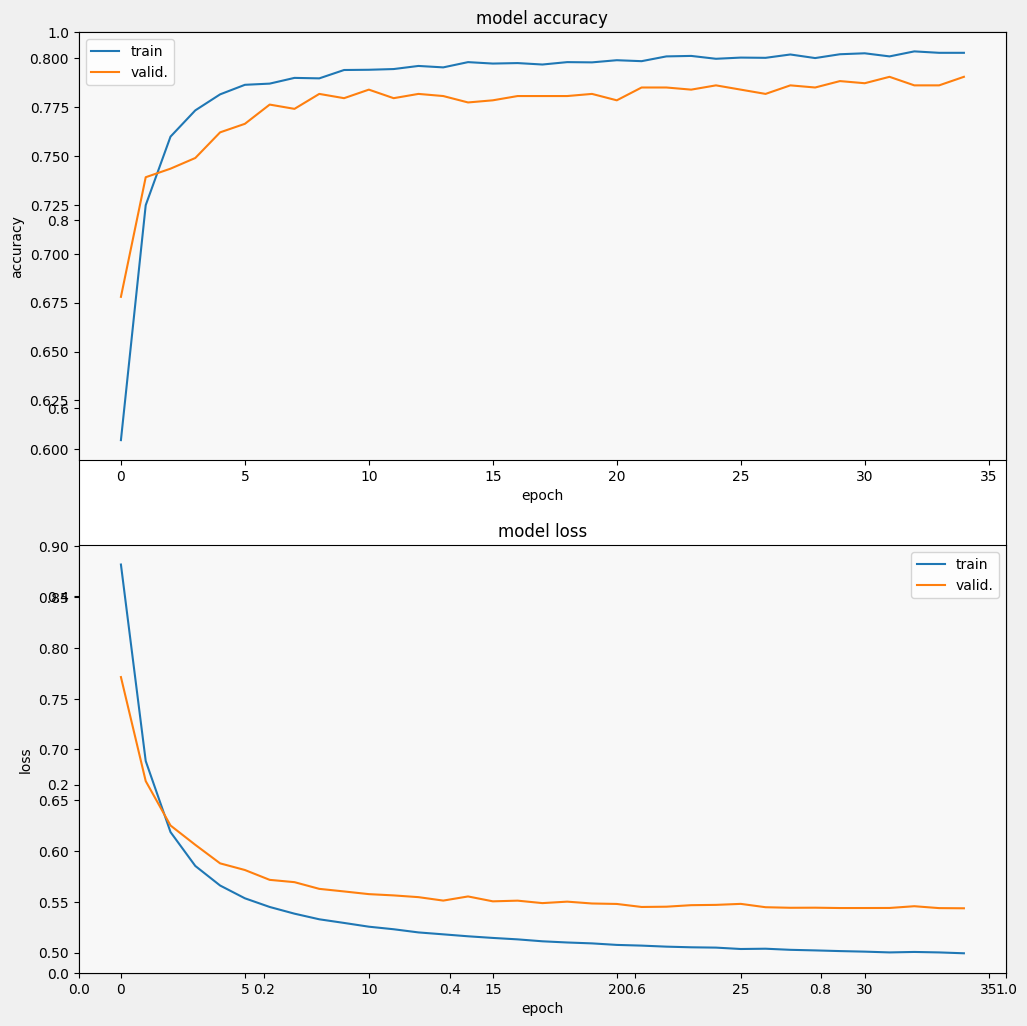

In [9]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## モデルを評価する

モデルがどのように実行するか見てみましょう。2 つの値が返されます。損失（誤差、値が低いほど良）と正確度です。

In [10]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print('%s: %.3f' % (name, value))

4/4 - 0s - loss: 0.5344 - accuracy: 0.7907 - 359ms/epoch - 90ms/step


loss: 0.534
accuracy: 0.791


損失はすぐに減少しますが、特に精度は急速に上がることが分かります。予測と真のラベルがどのように関係しているかを確認するために、いくつかの例をプロットしてみましょう。

In [11]:
prediction_dataset = next(iter(test_data.batch(20)))

prediction_texts = [ex.numpy().decode('utf8') for ex in prediction_dataset[0]]
prediction_labels = [label2str(x) for x in prediction_dataset[1]]

predictions = [
    label2str(x) for x in np.argmax(model.predict(prediction_texts), axis=-1)]


pd.DataFrame({
    TEXT_FEATURE_NAME: prediction_texts,
    LABEL_NAME: prediction_labels,
    'prediction': predictions
})

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 182ms/step


string       label  prediction
0   The diffraction grating, LED, and split detect...  background      method
1   Our ideas are based on a previous paper [4] de...  background      method
2   Our finding is consistent with the literature ...      result      result
3   Test scores from each of the cognitive domains...      method      method
4   The optimization algorithm was set to maximize...      method      method
5   To quantify the extent of substitution saturat...      method      method
6   Examples of gesture control are based on the e...      method      method
7   The identification of these features has been ...      method  background
8   Postulated mechanisms for observed effects of ...  background  background
9   The right inferior phrenic artery is the most ...  background  background
10  [8] presented an approach for estimating the t...  background      method
11  Similar structures were observed in M10 cells ...      result      method
12  Cytotoxic effects of cobalt chloride were repo...  background  background
13  However, prolonged incubation of latex enzyme ...  background  background
14  …and travels great distances, resulting in a s...  background  background
15  The images fused using region selection; MSD, ...      method      method
16  These findings were expected, as EMG activity ...      result  background
17  The model has been extended to both 2D and 3D ...      method  background
18  Therefore, many authors claim comprehensive nu...  background      method
19  Similar to Ab40, IAPP-GI populates an aggregat...  background  background

このランダムサンプルでは、ほとんどの場合、モデルが正しいラベルを予測しており、科学的な文をうまく埋め込むことができていることが分かります。

# 次のステップ

TF-Hub の CORD-19 Swivel 埋め込みについて少し説明しました。COVID-19 関連の学術的なテキストから科学的洞察の取得に貢献できる、CORD-19 Kaggle コンペへの参加をお勧めします。

- [CORD-19 Kaggle Challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) に参加しましょう。
- 詳細については [COVID-19 Open Research Dataset (CORD-19)](https://api.semanticscholar.org/CorpusID:216056360) をご覧ください。
- TF-Hub 埋め込みに関する詳細のドキュメントは https://tfhub.dev/tensorflow/cord-19/swivel-128d/3 をご覧ください。
- [TensorFlow Embedding Projector](http://projector.tensorflow.org/?config=https://storage.googleapis.com/tfhub-examples/tensorflow/cord-19/swivel-128d/3/tensorboard/projector_config.json) を利用して CORD-19 埋め込み空間を見てみましょう。